### Introducion:
In today's digital world, social media plays a very important role in our day to day life. From education to entertaintment, all is right now in the palm of a hand because of social media. YouTube is a big player in the market of socail media, so in this assignment, we will try to cluster videos based on their topics and their popularity metrics. This dataset is based on trending videos of a certain time period of 2017-18 of India. As India is a very diverse country and mostly each state has its own language and so is the data. For simplicity we are going to detect language as much as possible and drop the non-english rows. 

The numerical metrics: views, likes, comment count, dislikes will definately have some correlation and the data will be skewed. So we would need scaling.

### Library

In [284]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from langdetect import detect,LangDetectException
from tqdm import tqdm
import string,time
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import zscore
import nltk
from sklearn.cluster import DBSCAN
nltk.download('stopwords')
nltk.download('punkt')
from mpl_toolkits.mplot3d import Axes3D
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')  
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import plotly.express as px
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
import re
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from rich import print
from kneed import KneeLocator 
from scipy import stats
import plotly.graph_objects as go
from wordcloud import WordCloud
import scipy.cluster.hierarchy as sch

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ashish\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Data 
source:
https://media.githubusercontent.com/media/ashutoshkrris/YouTube-Trending-Videos-Analysis/refs/heads/master/dataset/INvideos.csv

In [202]:
df=pd.read_csv(r"C:\Users\Ashish\Documents\Python VScode\DATA Set\my_data_yt.csv")
print(df.shape)
print(df.info())

(37352, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                37352 non-null  object
 1   trending_date           37352 non-null  object
 2   title                   37352 non-null  object
 3   channel_title           37352 non-null  object
 4   category_id             37352 non-null  int64 
 5   publish_time            37352 non-null  object
 6   tags                    37352 non-null  object
 7   views                   37352 non-null  int64 
 8   likes                   37352 non-null  int64 
 9   dislikes                37352 non-null  int64 
 10  comment_count           37352 non-null  int64 
 11  thumbnail_link          37352 non-null  object
 12  comments_disabled       37352 non-null  bool  
 13  ratings_disabled        37352 non-null  bool  
 14  video_error_or_removed  37352 non-null  bool  
 15  de

None

video_id: A unique identifier for each video.

trending_date: The date when the video started trending.

title: The title of the video.

channel_title: The name of the YouTube channel that published the video.

category_id: A numerical ID representing the category of the video (e.g., Music, Gaming).

publish_time: The date and time when the video was published.

tags: Keywords or tags associated with the video.

views: The total number of views the video has received.

likes: The total number of likes the video has received.

dislikes: The total number of dislikes the video has received.

comment_count: The number of comments on the video.

thumbnail_link: A URL to the video's thumbnail image.

comments_disabled: A boolean or flag indicating whether comments are disabled for the video.

ratings_disabled: A boolean or flag indicating whether ratings (likes/dislikes) are disabled for the video.

video_error_or_removed: A boolean or flag indicating whether the video is unavailable (e.g., due to an error or removal).

description: The description text provided by the uploader for the video

We are not considering the trending date here, as we want to cluster on the basis of perfonance metrics and topics. 

In [203]:
df.isnull().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               561
dtype: int64

In [204]:
df.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,kzwfHumJyYc,17.14.11,Sharry Mann: Cute Munda ( Song Teaser) | Parmi...,Lokdhun Punjabi,1,2017-11-12T12:20:39.000Z,"sharry mann|""sharry mann new song""|""sharry man...",1096327,33966,798,882,https://i.ytimg.com/vi/kzwfHumJyYc/default.jpg,False,False,False,Presenting Sharry Mann latest Punjabi Song Cu...


### Function used throughout the code

In [206]:
lang_col=['title','tags','description','channel_title']
columns_to_normalize=['views','likes','dislikes','comment_count']
exclude=string.punctuation
stemmer=PorterStemmer()
scaler = MinMaxScaler()
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return " ".join(lemmatized_words)
def remove_spaces(title):
    return title.replace(' ', '')
def remove_punc(text):
    return text.translate(str.maketrans(exclude,' '*len(exclude)))
def remove_stopwords(text):
    new_text=[]
    for word in text.split():
        if word in stopwords.words('english'):
            new_text.append('')
        else:
            new_text.append(word)
    x=new_text[:]
    new_text.clear()
    return " ".join(x)
def stem_words(text):
    if isinstance(text, str):
        return " ".join([stemmer.stem(word) for word in text.split()])
def normalize(df,columns_to_normalize):
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df   
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'  
def remove_link(text):
    if isinstance(text, str):  
        match = re.search(r'(http[s]?://\S+|www\.\S+|#\S+)', text)
        if match:
            return text[:match.start()]
        else:
            return text
    else:
        return text
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    return tokens
def get_sentence_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  
def expand_vector_column(data,column_name, vector_size=100):
    return pd.DataFrame(data[column_name].to_list(), index=data.index, columns=[f"{column_name}_{i+1}" for i in range(vector_size)])
def apply_log_scaling(df, columns):
    df[columns] = df[columns].apply(lambda x: np.log(x + 1)) 
    return df

### Using Word2Vec

The description of videos has full of links and noise, so we have removed them using regex.

In [207]:
tqdm.pandas(desc='Removing link from description')
df['description']=df['description'].progress_apply(remove_link)

Removing link from description: 100%|██████████| 37352/37352 [00:00<00:00, 316525.66it/s]


#### Training Word2Vec

In [208]:
tags_tokens = df['tags'].apply(preprocess_text).tolist()
description_tokens = df['description'].apply(preprocess_text).tolist()
channel_title_tokens = df['channel_title'].apply(preprocess_text).tolist()
title_tokens = df['title'].apply(preprocess_text).tolist()

corpus = tags_tokens + description_tokens + channel_title_tokens + title_tokens
model = Word2Vec(vector_size=100, window=3, min_count=1, workers=4)
model.build_vocab(corpus)
model.train(corpus, total_examples=model.corpus_count, epochs=10)

(28531114, 30368310)

In [209]:
len(model.wv.key_to_index)

60939

### Basic EDA and Preprocessing

In [210]:
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%d.%m.%y', errors='coerce')
df['trending_day'] = df['trending_date'].dt.day_name()
day_counts = df['trending_day'].value_counts().reset_index()
day_counts.columns = ['Day', 'Count']
fig = px.bar(day_counts, x='Day', y='Count', title='Number of Videos Trending by Day', text='Count')
fig.update_layout(xaxis_title='Day of the Week', yaxis_title='Number of Videos')
fig.show()

The bar chart shows the number of videos trending by day of the week. Tuesday has the highest number of trending videos (2519), while Thursday has the lowest (1652). 

In [211]:
top_channels = df['channel_title'].value_counts().head(10).reset_index()
top_channels.columns = ['Channel', 'Count']

fig = px.bar(top_channels, x='Count', y='Channel', orientation='h', title='Top 10 Channels by Number of Trending Videos')
fig.update_layout(xaxis_title='Number of Videos', yaxis_title='Channel')
fig.show()

This bar graph shows the top 10 channels based on the number of trending videos they have.The channel with the most trending videos is Vijay Television, followed by ETV Jabardasth and then mallemalatv. The channel with the fewest trending videos in the top 10 is Vikatan TV.

Now dropping unnecessary columns.

In [212]:
df=df[df["video_error_or_removed"]==False]
df.drop(columns=["publish_time",
                "thumbnail_link","video_error_or_removed",
                "comments_disabled","ratings_disabled","trending_date"],
                inplace=True
        )

Many videos were trending for multiple days, so after removing the trending date, we have only kept the rows with highest likes and views as that would be the most updated one.

In [213]:
df.sort_values(by=['views', 'likes','video_id'], ascending=[False, False, False], inplace=True)
df.drop_duplicates(subset=['video_id','title','channel_title', 'tags', 'description'], keep='first', inplace=True)
tqdm.pandas(desc='Detecting language of title')
df['title_language'] = df['title'].progress_apply(detect_language)
tqdm.pandas(desc='Detecting language of title')
df['tags_language']=df['tags'].progress_apply(detect_language)
df=df[(df['title_language']=='en') & (df['tags_language']=='en') ]

Detecting language of title: 100%|██████████| 17324/17324 [02:18<00:00, 124.93it/s]


### EDA:

In [214]:
numerical_features = ['views', 'likes', 'dislikes', 'comment_count']
data = df["likes"]
mu, std = stats.norm.fit(data)
fig = px.histogram(data_frame=data,x="likes",nbins=50,marginal = "box", title="Distribution of Likes",opacity=0.7)
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
fig.add_trace(go.Scatter(x=x, y=p * data.shape[0] * (xmax - xmin) / 100, mode='lines',line=dict(color='red', width=2),name='Fitted Normal Distribution'))
fig.update_layout(xaxis_title="Likes", yaxis_title="Number of Videos", bargap=0.05)
fig.show()

Likes- The distribution is heavily right-skewed, with a long tail extending towards higher like counts. This means that most videos have a relatively small number of likes, while a few videos have a very large number of likes, suggesting the presence of viral or highly popular content.
In general, as seen from the plot , The majority of videos receive a relatively small number of likes, with a few outliers receiving a disproportionately large number.

In [215]:
data = df["views"]
mu, std = stats.norm.fit(data)
fig = px.histogram(data_frame=data,x="views",nbins=50, marginal="box",title="Distribution of Views",opacity=0.7,)
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
fig.add_trace(go.Scatter( x=x,y=p * data.shape[0] * (xmax - xmin) / 100,mode="lines",line=dict(color="red", width=2),name="Fitted Normal Distribution",))
fig.update_layout(xaxis_title="Views", yaxis_title="Number of Videos", bargap=0.05)
fig.show()

Views-  The right skew in views highlights the challenge of content discovery on YouTube. Most videos receive lower view counts, emphasizing the need for effective marketing and distribution strategies to reach a wider audience. However , some videos also have a large number of views which gives a clear message as seen in today's society as well- Very few videos go viral and captures a huge amount of audience whereas most of the videos fail to do so.

In [216]:
data = df["dislikes"]
mu, std = stats.norm.fit(data)
fig = px.histogram(data_frame=data,x="dislikes",nbins=50,marginal = "box", title="Distribution of Dislikes",opacity=0.7)
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
fig.add_trace(go.Scatter(x=x, y=p * data.shape[0] * (xmax - xmin) / 100, mode='lines',line=dict(color='red', width=2),name='Fitted Normal Distribution'))
fig.update_layout(xaxis_title="Dislikes", yaxis_title="Number of Videos", bargap=0.05)
fig.show()

Dislikes-  The distribution of dislikes is also right-skewed, although not as extreme as the likes and views distributions. This suggests that a smaller proportion of videos receive high dislike counts compared to high like or view counts. Most of the videos receive relatively low number of dislikes. This suggests that very few videos fail to capture the audience whereas most of the videos are able to perform well because of the audience diversity in India. This can be an important metric for  creators to improve upon their work if a video falls below a certain level in the society. 

In [217]:
data = df["comment_count"]
mu, std = stats.norm.fit(data)
fig = px.histogram(data_frame=data,x="comment_count",nbins=50,marginal = "box", title="Distribution of comment_count",opacity=0.7)
xmin, xmax = data.min(), data.max()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
fig.add_trace(go.Scatter(x=x, y=p * data.shape[0] * (xmax - xmin) / 100, mode='lines',line=dict(color='red', width=2),name='Fitted Normal Distribution'))
fig.update_layout(xaxis_title="comment_count", yaxis_title="Number of Videos", bargap=0.05)
fig.show()

Comments- Most videos have a lower comment count, with some attracting more discussion but not as many as the highly viewed or liked videos. This is an important metric as well to represent audience engagement. Creators can encourage comments by asking questions, responding to viewers' feedback, and creating content that sparks conversation. This can lead to increased viewer retention and loyalty. Videos with higher comment counts often suggest content that prompts discussion or raises  ideas. This can indicate high-quality content that sparks deeper audience engagement.

Since these numerical features is highly skewed, we have to scale the data. For this we are choosing logarithmic for handling the skewness and applying min max for normalizing.

In [218]:
corr_matrix = df[numerical_features].corr()
fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Magma',
    zmid=0,
    texttemplate="%{z:.2f}",
    textfont={"size": 12},
    hovertemplate='<b>%{x} vs %{y}</b><br>Correlation: %{z:.2f}<extra></extra>'
))
fig.update_layout(
    title='Correlation Matrix',
    xaxis_title='Numerical Metrics',
    yaxis_title='Numerical Metrics',
    font=dict(size=12),
    width=600,
    height=600
)
fig.show()

The correlation matrix shows strong positive relationships between views, likes, and comment conunt.

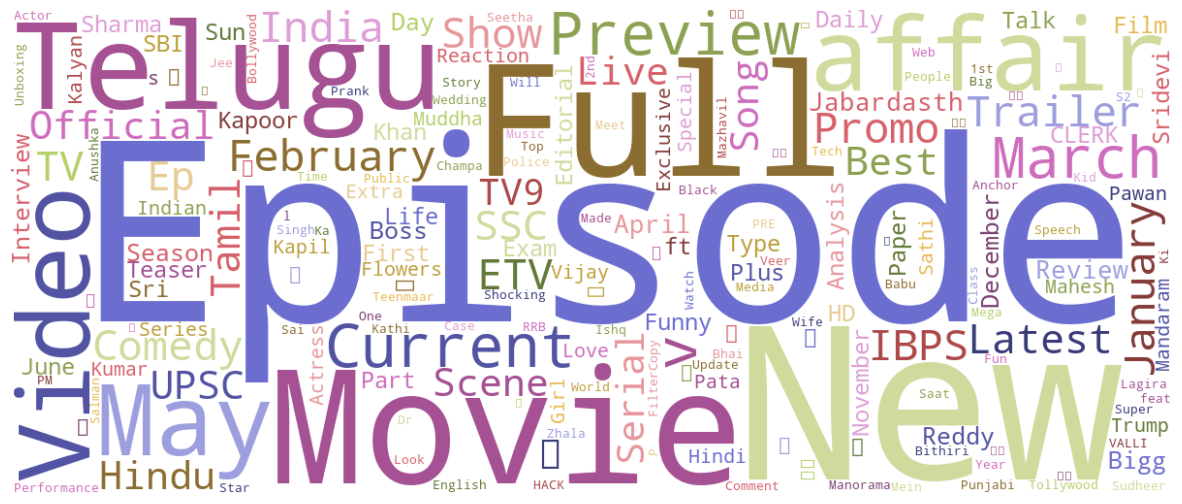

In [219]:
title_words = list(df["title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
wc = WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

By using wordcloud we have visualized the frequently occurring words in the title columns to identify common themes.

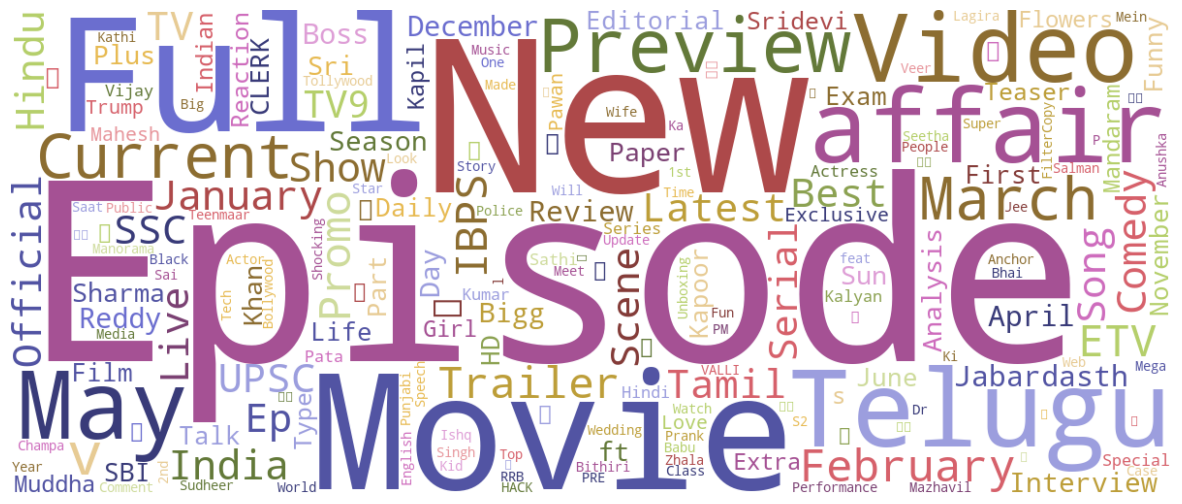

In [220]:
tags_words = list(df["tags"].apply(lambda x: x.split()))
tags_words = [x for y in tags_words for x in y]
wc = WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

Same for the tags to undersatnd the content trends and understand multilingual content by examining the most used words across different languages.

### Further pre-processing and applying word2vec:

In [221]:
df[lang_col]=df[lang_col].astype(str)
df[lang_col]=df[lang_col].apply(lambda x:x.str.lower())
tqdm.pandas(desc='removing punctuation, stopwords........')
df[lang_col]=df[lang_col].progress_apply(lambda x:x.apply(remove_punc))
df[lang_col]=df[lang_col].progress_apply(lambda x:x.apply(remove_stopwords))
for col in lang_col:
    df[col]=df[col].progress_apply(lemmatize_text)

df.reset_index(inplace=True,drop=True)
print(df.shape)
print(df.info())

removing punctuation, stopwords........: 100%|██████████| 6483/6483 [00:00<00:00, 123702.54it/s]


(6483, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6483 entries, 0 to 6482
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        6483 non-null   object
 1   title           6483 non-null   object
 2   channel_title   6483 non-null   object
 3   category_id     6483 non-null   int64 
 4   tags            6483 non-null   object
 5   views           6483 non-null   int64 
 6   likes           6483 non-null   int64 
 7   dislikes        6483 non-null   int64 
 8   comment_count   6483 non-null   int64 
 9   description     6483 non-null   object
 10  trending_day    2448 non-null   object
 11  title_language  6483 non-null   object
 12  tags_language   6483 non-null   object
dtypes: int64(5), object(8)
memory usage: 658.6+ KB


None

In [224]:
tqdm.pandas(desc='tokenzing textual columns....')
df['title_tokens'] =df['title'].progress_apply(preprocess_text)
df['channel_title_tokens']=df['channel_title'].progress_apply(preprocess_text)
df['tags_tokens'] = df['tags'].progress_apply(preprocess_text)
df['description_tokens'] = df['description'].progress_apply(preprocess_text)
df = apply_log_scaling(df,columns_to_normalize)
df= normalize(df, columns_to_normalize)
tqdm.pandas(desc='Applying embedding...')
df['vectorized1'] = df['tags_tokens'].progress_apply(lambda x: get_sentence_embedding(x, model))
df['vectorized2'] = df['title_tokens'].progress_apply(lambda x: get_sentence_embedding(x, model))
df['vectorized3'] = df['channel_title_tokens'].progress_apply(lambda x: get_sentence_embedding(x, model))
df['vectorized4'] = df['description_tokens'].progress_apply(lambda x: get_sentence_embedding(x, model))

Applying embedding...: 100%|██████████| 6483/6483 [00:00<00:00, 17995.94it/s]


In [229]:
df.drop(['trending_day'],axis=1,inplace=True)

In [230]:
df.head(1)

,video_id,title,channel_title,category_id,tags,views,likes,dislikes,comment_count,description,title_language,tags_language,title_tokens,channel_title_tokens,tags_tokens,description_tokens,vectorized1,vectorized2,vectorized3,vectorized4
0,FlsCjmMhFmw,youtube rewind shape 2017 youtuberewind,youtube spotlight,24,rewind rewind 2017 youtube rewind 2017 youtube...,1.0,1.0,1.0,1.0,youtube rewind 2017 celebrating video people m...,en,en,"[youtube, rewind, shape, youtuberewind]","[youtube, spotlight]","[rewind, rewind, youtube, rewind, youtuberewin...","[youtube, rewind, celebrating, video, people, ...","[-0.3448767, 0.09586365, -0.09153223, 0.523746...","[-0.9221613, -0.13711634, -0.12301269, 0.69159...","[-1.506194, -0.09764716, -0.2129422, 1.2360938...","[-0.7463425, 0.08163802, 0.11906205, 1.0647919..."


In [231]:
data=pd.concat([df.iloc[:,0:2],df.iloc[:,4:9],df.iloc[:,16:19]],axis=1)
data.head(4)

,video_id,title,tags,views,likes,dislikes,comment_count,vectorized1,vectorized2,vectorized3
0,FlsCjmMhFmw,youtube rewind shape 2017 youtuberewind,rewind rewind 2017 youtube rewind 2017 youtube...,1.000000,1.000000,1.000000,1.000000,"[-0.3448767, 0.09586365, -0.09153223, 0.523746...","[-0.9221613, -0.13711634, -0.12301269, 0.69159...","[-1.506194, -0.09764716, -0.2129422, 1.2360938..."
1,6ZfuNTqbHE8,marvel studio avenger infinity war official tr...,marvel comic comic book nerdy geeky super hero...,0.779854,0.922142,0.048670,0.516929,"[-0.14771782, 0.20484164, 0.427132, 0.59655035...","[-0.17531939, 0.21886186, -0.53982323, 1.31460...","[-0.78676397, 0.22881283, -0.7661827, 0.431677..."
2,u9Mv98Gr5pY,venom official trailer hd,venom venom movie venom 2018 marvel marvel com...,0.515087,0.515346,0.041234,0.223635,"[-0.01306365, 0.2255377, -0.22795646, 0.347072...","[-0.38724244, 0.47148687, -0.8942507, 1.037275...","[-0.21906222, 0.19682032, -0.45419136, 0.45494..."
3,QwievZ1Tx-8,marvel studio avenger infinity war official tr...,marvel comic comic book nerd geek superhero su...,0.442816,0.597666,0.027572,0.299046,"[-0.13105826, -0.04218465, 0.41596463, 0.23070...","[-0.17531939, 0.21886186, -0.53982323, 1.31460...","[-0.78676397, 0.22881283, -0.7661827, 0.431677..."


In [232]:
vector_columns = ['vectorized1', 'vectorized2','vectorized3']
numerical_columns=['views','likes','dislikes','comment_count']
vector_size = 100 
expanded_vector_data = pd.concat([expand_vector_column(data, col, vector_size) for col in vector_columns], axis=1)

### Outlier detection

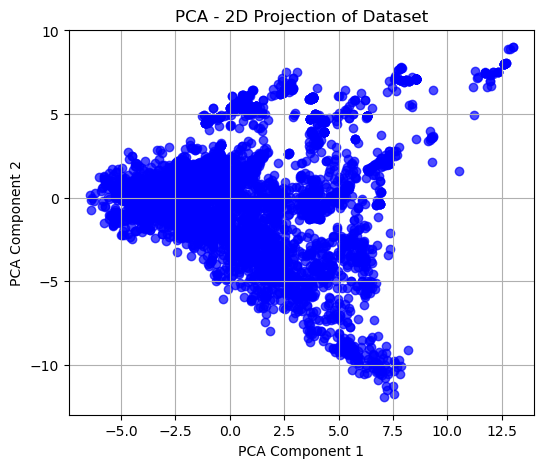

Isolation Forest Outliers: 325

LOF Outliers: 325

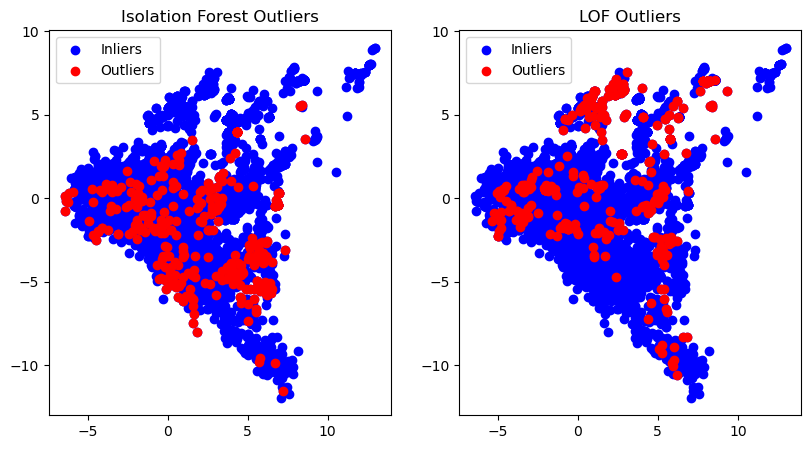

In [233]:
data_with_vectors = pd.concat([data.iloc[:,0:2],data[numerical_columns],expanded_vector_data], axis=1)

pca = PCA(n_components=.90)  
X_pca = pca.fit_transform(data_with_vectors.drop(columns=['video_id','title']))
n_components = pca.n_components_
X_pca = pd.DataFrame(X_pca, columns=[f'PCA{i+1}' for i in range(n_components)])
plt.figure(figsize=(6, 5))
plt.scatter(X_pca['PCA1'], X_pca['PCA2'], alpha=0.7, c='blue') 
plt.title("PCA - 2D Projection of Dataset")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 5))

model = IsolationForest(contamination=0.05)
iforest_outliers = model.fit_predict(X_pca)
outliers_if = np.where(iforest_outliers == -1)
plt.subplot(1, 3, 2)
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c='blue', label='Inliers')
plt.scatter(X_pca.iloc[outliers_if[0], 0], X_pca.iloc[outliers_if[0], 1], c='red', label='Outliers')
plt.title("Isolation Forest Outliers")
plt.legend()

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_outliers = lof.fit_predict(X_pca)
outliers_lof = np.where(lof_outliers == -1)
plt.subplot(1, 3, 3)
plt.scatter(X_pca.iloc[:, 0], X_pca.iloc[:, 1], c='blue', label='Inliers')
plt.scatter(X_pca.iloc[outliers_lof[0], 0], X_pca.iloc[outliers_lof[0], 1], c='red', label='Outliers')
plt.title("LOF Outliers")
plt.legend()

print("Isolation Forest Outliers:", len(outliers_if[0]))
print("LOF Outliers:", len(outliers_lof[0]))

plt.show()

In [234]:
outliers_union = np.where((lof_outliers == -1) | (iforest_outliers == -1))[0]
data.drop(outliers_union,axis=0,inplace=True)
data.reset_index(drop=True,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5871 entries, 0 to 5870
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       5871 non-null   object 
 1   title          5871 non-null   object 
 2   tags           5871 non-null   object 
 3   views          5871 non-null   float64
 4   likes          5871 non-null   float64
 5   dislikes       5871 non-null   float64
 6   comment_count  5871 non-null   float64
 7   vectorized1    5871 non-null   object 
 8   vectorized2    5871 non-null   object 
 9   vectorized3    5871 non-null   object 
dtypes: float64(4), object(6)
memory usage: 458.8+ KB


### Clustering using unsupervised models

#### PCA

Number of components to explain 90.09767349153061% variance: 74

Explained variance ratio of the components: [0.10509204 0.08329476 0.0653012  0.05314111 0.04786987 0.03733585
 0.03180701 0.02898577 0.02574778 0.02217347 0.02169743 0.0204799
 0.01815826 0.01725211 0.01647073 0.01444278 0.01399033 0.01294659
 0.01226405 0.0113663  0.01043726 0.01019916 0.00933372 0.00894502
 0.00862388 0.00805216 0.00780343 0.00754418 0.00726864 0.00686848
 0.00672331 0.0064059  0.00613217 0.00585334 0.00566195 0.00544578
 0.0052089  0.00504657 0.00495245 0.00484452 0.00457137 0.00453423
 0.00437301 0.00433004 0.00412243 0.00391382 0.00377705 0.00363294
 0.00353876 0.00345573 0.00339467 0.00325713 0.00313535 0.00309586
 0.00293195 0.00290154 0.00273691 0.00270823 0.00261711 0.00257239
 0.00249916 0.00243698 0.00236742 0.00233953 0.00228586 0.00223888
 0.00217641 0.00212377 0.00205508 0.00202403 0.00198311 0.00195568
 0.00187319 0.00184896]

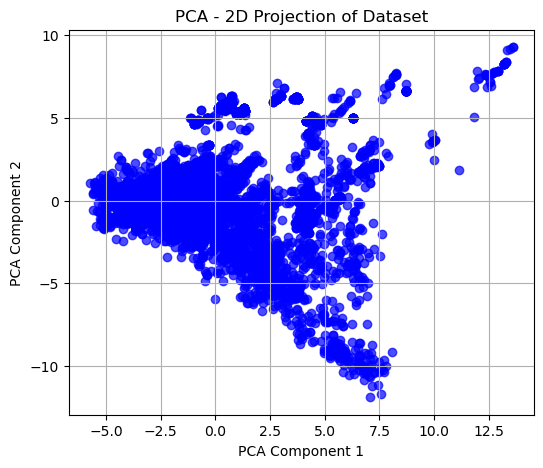

In [293]:
expanded_vector_data = pd.concat([expand_vector_column(data, col, vector_size) for col in vector_columns], axis=1)
data_with_vectors = pd.concat([data.iloc[:,0:2],expanded_vector_data], axis=1)
pca = PCA(n_components=.90)  
X_pca = pca.fit_transform(data_with_vectors.drop(columns=['video_id','title']))
n_components = pca.n_components_
print(f"Number of components to explain {sum(pca.explained_variance_ratio_)*100}% variance: {n_components}")
final_data = pd.DataFrame(X_pca, columns=[f'PCA{i+1}' for i in range(n_components)])
final_data = pd.concat([data_with_vectors.iloc[:,:2],final_data],axis=1)

print(f"Explained variance ratio of the components: {pca.explained_variance_ratio_}")

plt.figure(figsize=(6, 5))
plt.scatter(final_data['PCA1'], final_data['PCA2'], alpha=0.7, c='blue') 
plt.title("PCA - 2D Projection of Dataset")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

#### KMeans

##### Based on title and tags

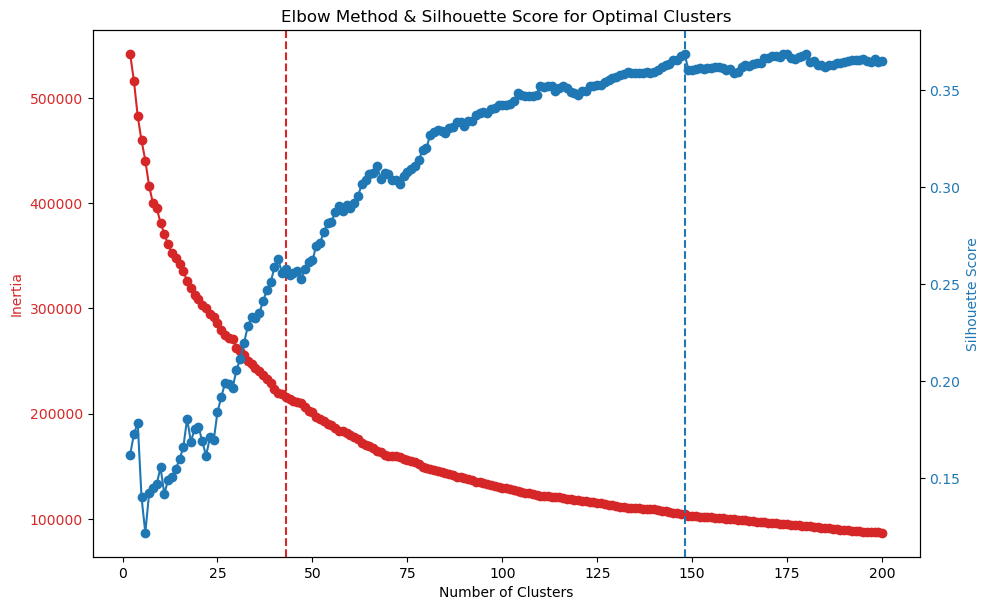

In [294]:
inertia = []
silhouette_scores = []

for n_clusters in range(2,201):
    kmeans = KMeans(n_clusters=n_clusters, max_iter=450, random_state=42)
    kmeans.fit(final_data.drop(columns=['video_id','title']))
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(final_data.drop(columns=['video_id','title']), kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

optimal_clusters_silhouette = range(2, 201)[silhouette_scores.index(max(silhouette_scores))]
knee_locator = KneeLocator(range(2, 201), inertia, curve='convex', direction='decreasing')
optimal_clusters_elbow = knee_locator.elbow

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='tab:red')
ax1.plot(range(2, 201), inertia, 
        color='tab:red', 
        marker='o', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  
ax2.set_ylabel('Silhouette Score', color='tab:blue')
ax2.plot(range(2,201), silhouette_scores,
         color='tab:blue', 
         marker='o', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax1.axvline(x=optimal_clusters_elbow, color='tab:red', linestyle='--', label=f'Optimal (Elbow) = {optimal_clusters_elbow}')
ax2.axvline(x=optimal_clusters_silhouette, color='tab:blue', linestyle='--', label=f'Optimal (Silhouette) = {optimal_clusters_silhouette}')

fig.tight_layout()  
plt.title('Elbow Method & Silhouette Score for Optimal Clusters')
plt.show()

In [300]:
print(f"Optimal number of clusters (Elbow method): {optimal_clusters_elbow}")
print(f"Optimal number of clusters (Silhouette method): {optimal_clusters_silhouette}")

Optimal number of clusters (Elbow method): 43

Optimal number of clusters (Silhouette method): 148

Silhouette Score for 43 clusters: 0.2343

Davies-Bouldin Index: 1.7014236173110875

Calinski-Harabasz Index: 287.4823643621822

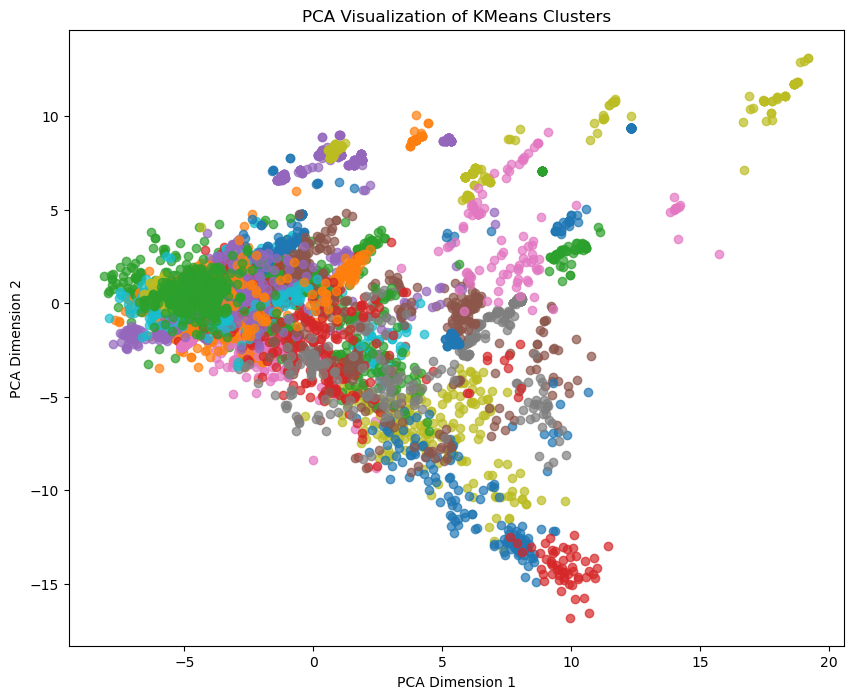

In [301]:
num_clusters = 43
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
final_data['cluster'] = kmeans.fit_predict(final_data.drop(columns=['video_id','title']))
labels = kmeans.labels_
silhouette_avg = silhouette_score(final_data.drop(columns=['cluster','video_id','title']), final_data['cluster'])
print(f"Silhouette Score for {num_clusters} clusters: {silhouette_avg:.4f}")

db_score = davies_bouldin_score(final_data.drop(columns=['video_id','cluster','title']), labels)
print(f"Davies-Bouldin Index: {db_score}")


ch_score = calinski_harabasz_score(final_data.drop(columns=['video_id', 'cluster','title']), labels)
print(f"Calinski-Harabasz Index: {ch_score}")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(final_data.drop(columns=['cluster','video_id','title']))
final_data['pca_x'] = X_pca[:, 0]
final_data['pca_y'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))

for cluster in range(num_clusters):
    clustered_points = final_data[final_data['cluster'] == cluster]
    plt.scatter(clustered_points['pca_x'], clustered_points['pca_y'], label=f"Cluster {cluster}", alpha=0.7)

plt.title("PCA Visualization of KMeans Clusters")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

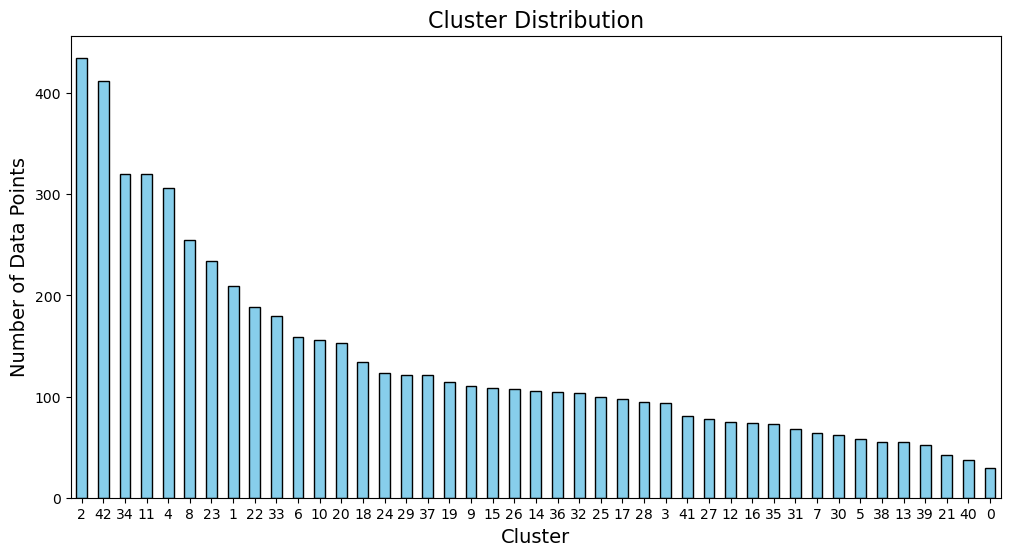

In [302]:
cluster_counts = final_data['cluster'].value_counts()
plt.figure(figsize=(12,6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Cluster Distribution', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.xticks(rotation=0)
plt.show()

In [303]:
final_data.head()

,video_id,title,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,...,PCA68,PCA69,PCA70,PCA71,PCA72,PCA73,PCA74,cluster,pca_x,pca_y
0,FlsCjmMhFmw,youtube rewind shape 2017 youtuberewind,-0.704832,-0.604089,-0.633069,1.396146,-0.559777,0.439897,0.981625,0.398734,...,0.537006,0.249163,-1.511411,0.987118,0.609371,0.010277,-0.346667,34,-0.996783,-0.854311
1,6ZfuNTqbHE8,marvel studio avenger infinity war official tr...,1.360212,-0.851824,-3.236546,-1.387015,1.990309,1.559659,4.424018,-4.310186,...,0.845737,-1.023025,-0.036628,-0.611489,0.281348,0.356716,-0.705439,27,1.923630,-1.204661
2,u9Mv98Gr5pY,venom official trailer hd,2.170662,0.418880,-1.618220,-0.354273,4.037919,0.836004,3.786030,-4.416814,...,0.680910,-0.901112,-0.157797,0.189281,-0.179111,0.507744,-0.295575,27,3.069780,0.592386
3,QwievZ1Tx-8,marvel studio avenger infinity war official tr...,1.191878,-1.047618,-3.243398,-0.928999,1.914468,1.547619,4.280418,-4.098687,...,0.977536,-1.309069,0.037260,-0.323364,0.179175,0.481031,-0.715656,27,1.685571,-1.481555
4,tCXGJQYZ9JA,taylor swift delicate,-3.309672,0.799188,0.477929,0.980758,-0.470206,0.915995,1.055622,0.552062,...,-0.112609,0.009054,0.099549,0.105467,-0.166564,-0.632913,-0.132295,42,-4.680583,1.130223


In [304]:
final_data1=pd.concat([final_data.iloc[:,:2],data[numerical_columns],final_data.iloc[:,76]],axis=1)
final_data1=normalize(final_data1,["cluster"])
final_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5871 entries, 0 to 5870
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       5871 non-null   object 
 1   title          5871 non-null   object 
 2   views          5871 non-null   float64
 3   likes          5871 non-null   float64
 4   dislikes       5871 non-null   float64
 5   comment_count  5871 non-null   float64
 6   cluster        5871 non-null   float64
dtypes: float64(5), object(2)
memory usage: 321.2+ KB


##### Based on views,likes,dislikes,comment count 

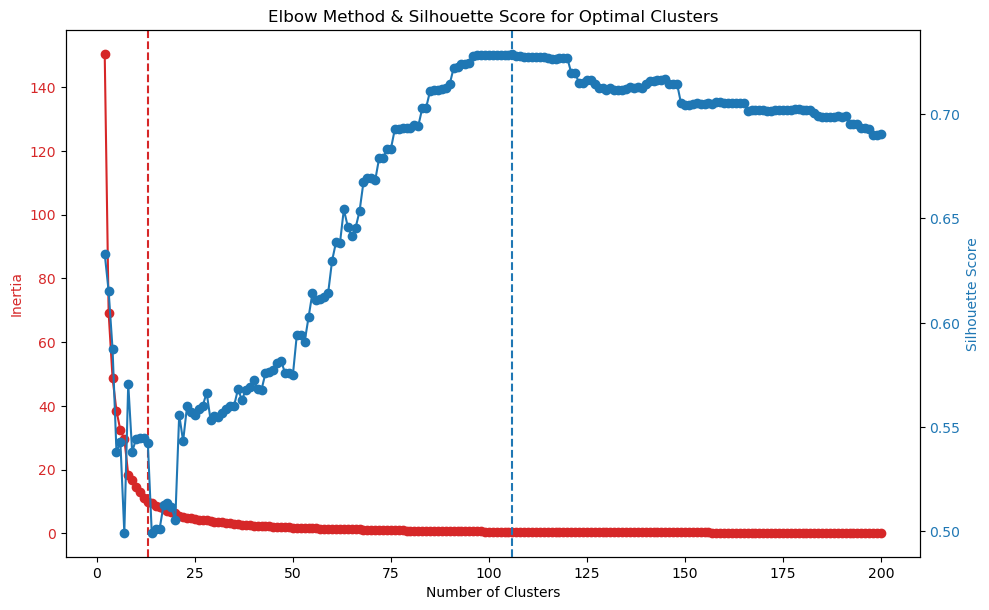

In [305]:
inertia = []
silhouette_scores = []

for n_clusters in range(2,201):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(final_data1.drop(columns=['video_id','title']))
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(final_data1.drop(columns=['video_id','title']), kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

optimal_clusters_silhouette = range(2, 201)[silhouette_scores.index(max(silhouette_scores))]
knee_locator = KneeLocator(range(2, 201), inertia, curve='convex', direction='decreasing')
optimal_clusters_elbow = knee_locator.elbow

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color='tab:red')
ax1.plot(range(2, 201), inertia, 
        color='tab:red', 
        marker='o', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  
ax2.set_ylabel('Silhouette Score', color='tab:blue')
ax2.plot(range(2,201), silhouette_scores,
         color='tab:blue', 
         marker='o', label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax1.axvline(x=optimal_clusters_elbow, color='tab:red', linestyle='--', label=f'Optimal (Elbow) = {optimal_clusters_elbow}')
ax2.axvline(x=optimal_clusters_silhouette, color='tab:blue', linestyle='--', label=f'Optimal (Silhouette) = {optimal_clusters_silhouette}')

fig.tight_layout()  
plt.title('Elbow Method & Silhouette Score for Optimal Clusters')
plt.show()

In [306]:
print(f"Optimal number of clusters (Elbow method): {optimal_clusters_elbow}")
print(f"Optimal number of clusters (Silhouette method): {optimal_clusters_silhouette}")

Optimal number of clusters (Elbow method): 13

Optimal number of clusters (Silhouette method): 106

Silhouette Score for 13 clusters: 0.5423

Davies-Bouldin Index: 1.0420483722485292

Calinski-Harabasz Index: 5450.001931835013

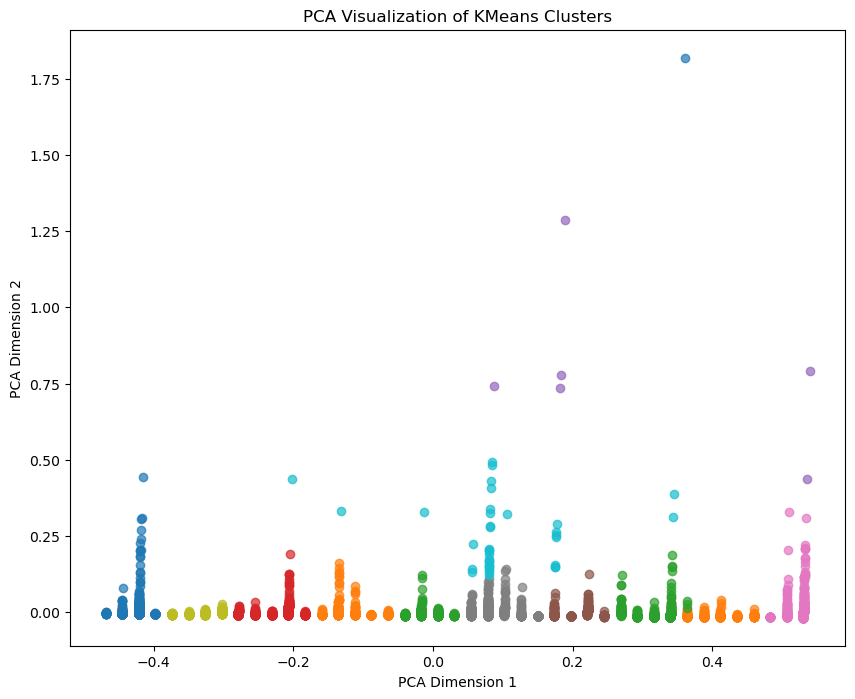

In [307]:
num_clusters = 13
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
final_data1['cluster_new'] = kmeans.fit_predict(final_data1.drop(columns=['video_id','title']))

silhouette_avg = silhouette_score(final_data1.drop(columns=['video_id','title','cluster_new']), final_data1['cluster_new'])
print(f"Silhouette Score for {num_clusters} clusters: {silhouette_avg:.4f}")
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(final_data1.drop(columns=['video_id', 'title','cluster_new']), labels)
print(f"Davies-Bouldin Index: {db_score}")

from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(final_data1.drop(columns=['video_id', 'title','cluster_new']), labels)
print(f"Calinski-Harabasz Index: {ch_score}")

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(final_data1.drop(columns=['video_id','title','cluster_new']))


final_data1['pca_x'] = X_pca[:, 0]
final_data1['pca_y'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))

for cluster in range(num_clusters):
    clustered_points = final_data1[final_data1['cluster_new'] == cluster]
    plt.scatter(clustered_points['pca_x'], clustered_points['pca_y'], label=f"Cluster {cluster}", alpha=0.7)


plt.title("PCA Visualization of KMeans Clusters")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.show()

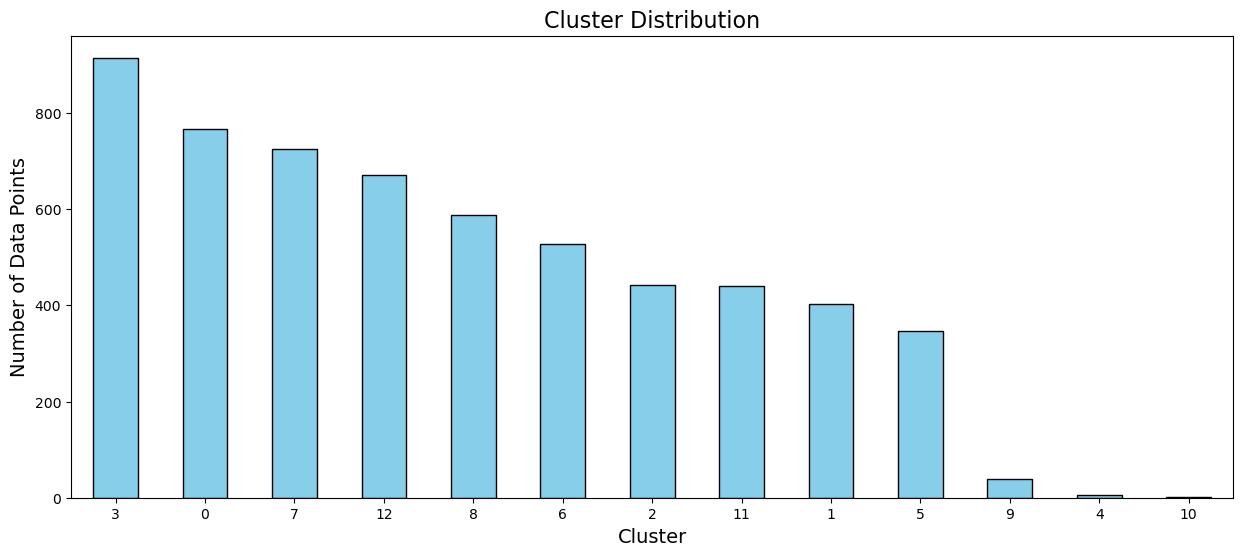

In [308]:
cluster_counts = final_data1['cluster_new'].value_counts()
plt.figure(figsize=(15, 6))

cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Cluster Distribution', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Number of Data Points', fontsize=14)
plt.xticks(rotation=0)
plt.show()

#### DBSCAN

In [253]:
final_data.drop(columns=['cluster','pca_x','pca_y'],inplace=True)
final_data1.drop(columns=['cluster','pca_x','pca_y','cluster_new'],inplace=True)

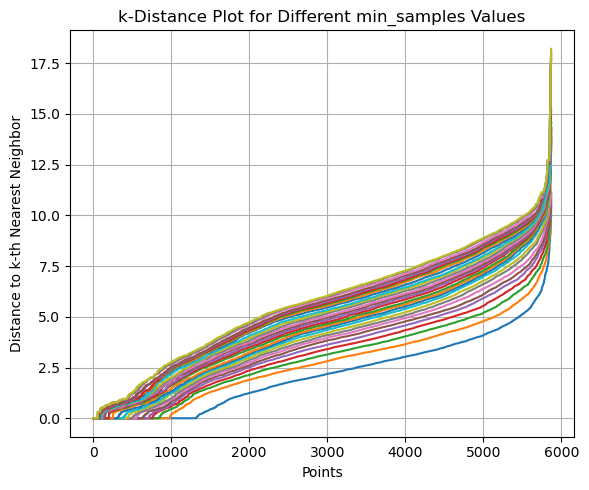

In [255]:
plt.figure(figsize=(6, 5))
min_samples_values = range(2, 31) 

for min_samples in min_samples_values:
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(final_data.iloc[:,2:])
    distances, indices = neigh.kneighbors(final_data.iloc[:,2:])

    distances = np.sort(distances[:, min_samples - 1], axis=0)
    plt.plot(distances, label=f'min_samples={min_samples}')

plt.title('k-Distance Plot for Different min_samples Values')
plt.xlabel('Points')
plt.ylabel('Distance to k-th Nearest Neighbor')
plt.grid(True)
plt.tight_layout()
plt.show()

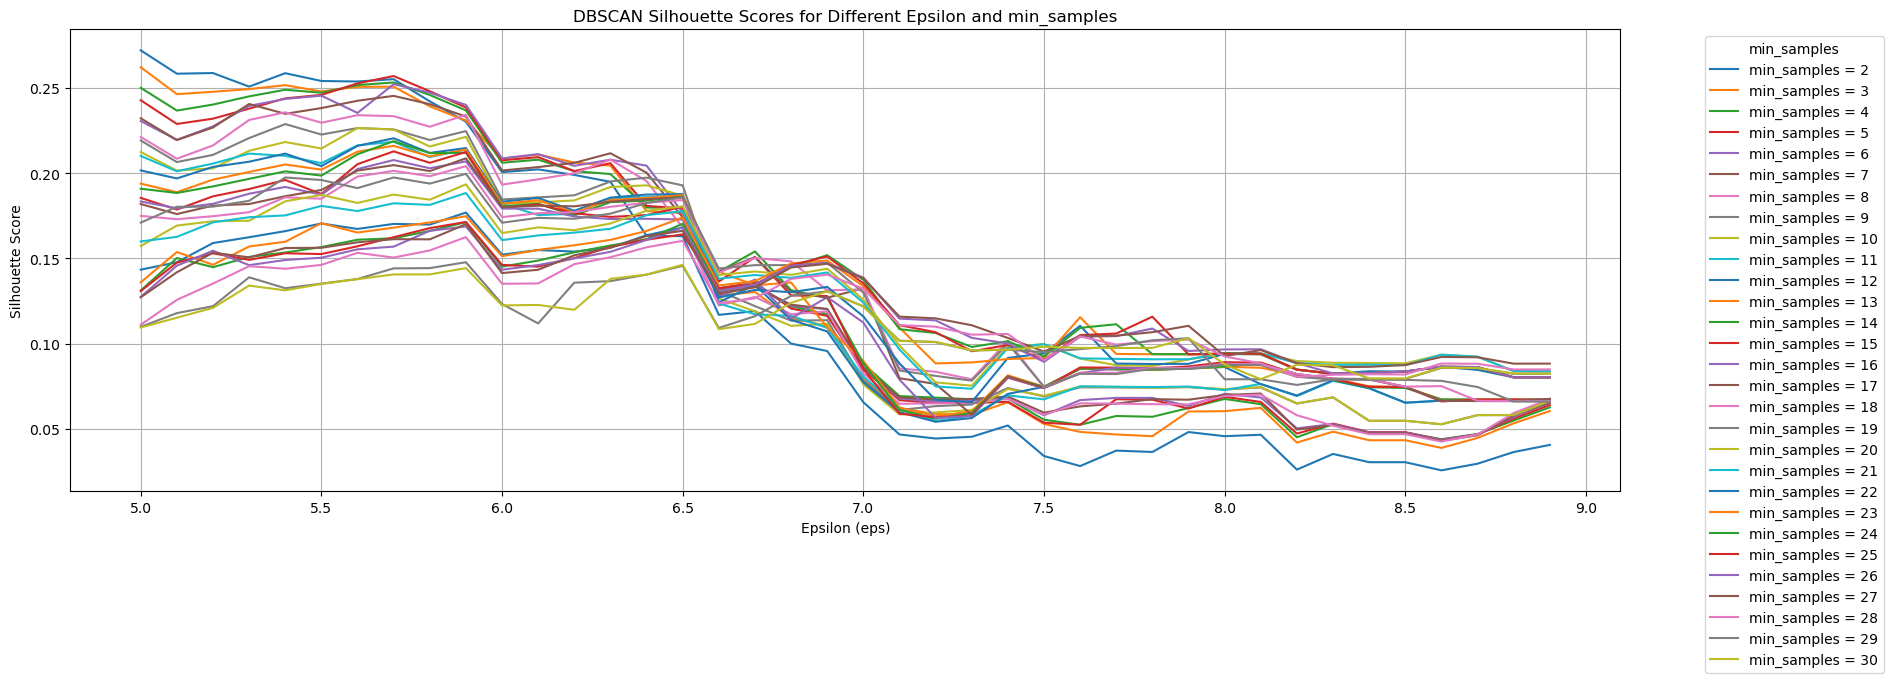

In [256]:
eps_values = np.arange(5.0, 9.0, 0.1)  
min_samples_values = list(range(2, 31)) 

silhouette_scores = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(final_data.iloc[:,2:])
        if len(set(dbscan_labels)) > 1:  
            score = silhouette_score(final_data.drop(columns=['video_id','title']), dbscan_labels)
        else:
            score = -1  
        silhouette_scores.append((eps, min_samples, score))


silhouette_df = pd.DataFrame(silhouette_scores, columns=['eps', 'min_samples', 'silhouette_score'])

fig, ax = plt.subplots(figsize=(20, 6))
for min_samples in min_samples_values:
    subset = silhouette_df[silhouette_df['min_samples'] == min_samples]
    ax.plot(subset['eps'], subset['silhouette_score'], label=f"min_samples = {min_samples}")

ax.set_xlabel('Epsilon (eps)')
ax.set_ylabel('Silhouette Score')
ax.set_title('DBSCAN Silhouette Scores for Different Epsilon and min_samples')
ax.legend(title='min_samples', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

best_params = silhouette_df.loc[silhouette_df['silhouette_score'].idxmax()]
best_eps = best_params['eps']
best_min_samples = best_params['min_samples']

In [257]:
best_min_samples=int(best_min_samples)
best_eps=int(best_eps)
print(best_min_samples,best_eps)
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
final_data['cluster'] = dbscan.fit_predict(final_data.iloc[:,2:])
labels=dbscan_labels


silhouette_avg = silhouette_score(final_data.iloc[:, 2:].drop('cluster',axis=1), labels)
print(f"Silhouette Score: {silhouette_avg}")
db_score = davies_bouldin_score(final_data.iloc[:, 2:].drop('cluster',axis=1), labels)
print(f"Davies-Bouldin Index: {db_score}")
ch_score = calinski_harabasz_score(final_data.iloc[:, 2:].drop('cluster',axis=1), labels)
print(f"Calinski-Harabasz Index: {ch_score}")
noise_points = np.sum(labels == -1)
print(f"Number of noise points: {noise_points}")


2 5

Silhouette Score: 0.08241193237577166

Davies-Bouldin Index: 1.9296431461254526

Calinski-Harabasz Index: 112.93841757632805

Number of noise points: 304

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5871 entries, 0 to 5870
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       5871 non-null   object 
 1   title          5871 non-null   object 
 2   views          5871 non-null   float64
 3   likes          5871 non-null   float64
 4   dislikes       5871 non-null   float64
 5   comment_count  5871 non-null   float64
 6   cluster        5871 non-null   float64
dtypes: float64(5), object(2)
memory usage: 321.2+ KB


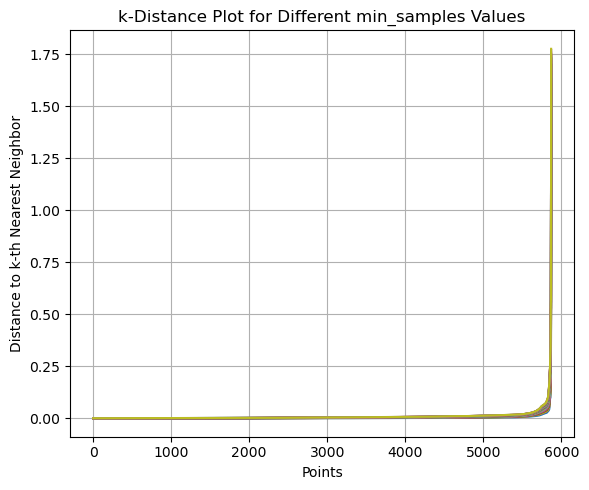

In [275]:
final_data1=pd.concat([final_data.iloc[:,:2],data[numerical_columns],final_data.iloc[:,76]],axis=1)
final_data1=normalize(final_data1,["cluster"])
final_data1.info()
plt.figure(figsize=(6, 5))
min_samples_values = range(2, 31) 

for min_samples in min_samples_values:
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(final_data1.iloc[:,2:])
    distances, indices = neigh.kneighbors(final_data1.iloc[:,2:])

    distances = np.sort(distances[:, min_samples - 1], axis=0)
    plt.plot(distances, label=f'min_samples={min_samples}')

plt.title('k-Distance Plot for Different min_samples Values')
plt.xlabel('Points')
plt.ylabel('Distance to k-th Nearest Neighbor')
plt.grid(True)
plt.tight_layout()
plt.show()

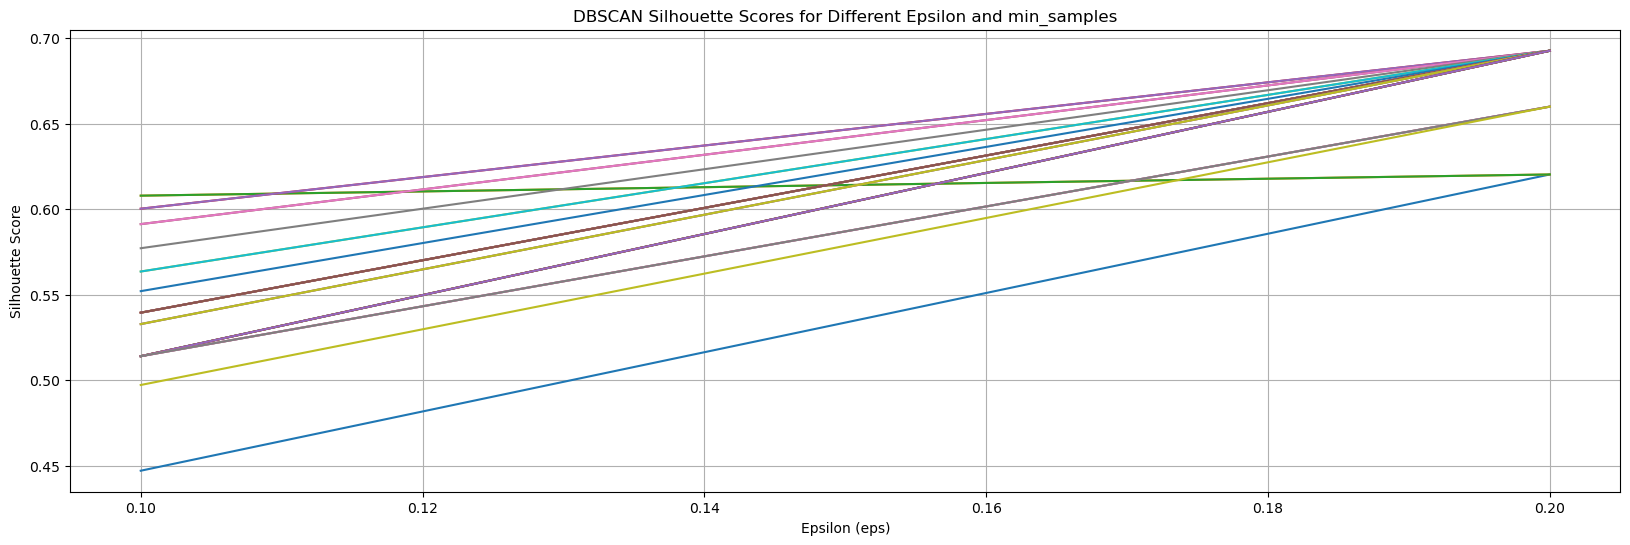

In [276]:
eps_values = np.arange(0.1,0.25,0.1)  
min_samples_values = list(range(2, 31)) 

silhouette_scores = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(final_data1.iloc[:,2:])
        if len(set(dbscan_labels)) > 1:  
            score = silhouette_score(final_data1.drop(columns=['video_id','title']), dbscan_labels)
        else:
            score = -1  
        silhouette_scores.append((eps, min_samples, score))


silhouette_df = pd.DataFrame(silhouette_scores, columns=['eps', 'min_samples', 'silhouette_score'])

fig, ax = plt.subplots(figsize=(20, 6))
for min_samples in min_samples_values:
    subset = silhouette_df[silhouette_df['min_samples'] == min_samples]
    ax.plot(subset['eps'], subset['silhouette_score'], label=f"min_samples = {min_samples}")

ax.set_xlabel('Epsilon (eps)')
ax.set_ylabel('Silhouette Score')
ax.set_title('DBSCAN Silhouette Scores for Different Epsilon and min_samples')
plt.grid()
plt.show()

best_params = silhouette_df.loc[silhouette_df['silhouette_score'].idxmax()]
best_eps = best_params['eps']
best_min_samples = best_params['min_samples']

In [277]:
best_min_samples=int(best_min_samples)
best_eps=float(best_eps)
print(best_min_samples,best_eps)
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
final_data1['cluster_new'] = dbscan.fit_predict(final_data1.iloc[:,2:])
labels=dbscan_labels


silhouette_avg = silhouette_score(final_data1.iloc[:, 2:].drop('cluster_new',axis=1), labels)
print(f"Silhouette Score: {silhouette_avg}")
db_score = davies_bouldin_score(final_data1.iloc[:, 2:].drop('cluster_new',axis=1), labels)
print(f"Davies-Bouldin Index: {db_score}")
ch_score = calinski_harabasz_score(final_data1.iloc[:, 2:].drop('cluster_new',axis=1), labels)
print(f"Calinski-Harabasz Index: {ch_score}")
noise_points = np.sum(labels == -1)
print(f"Number of noise points: {noise_points}")


5 0.2

Silhouette Score: 0.6599042569827472

Davies-Bouldin Index: 0.8232313198173962

Calinski-Harabasz Index: 74.83063005401026

Number of noise points: 9

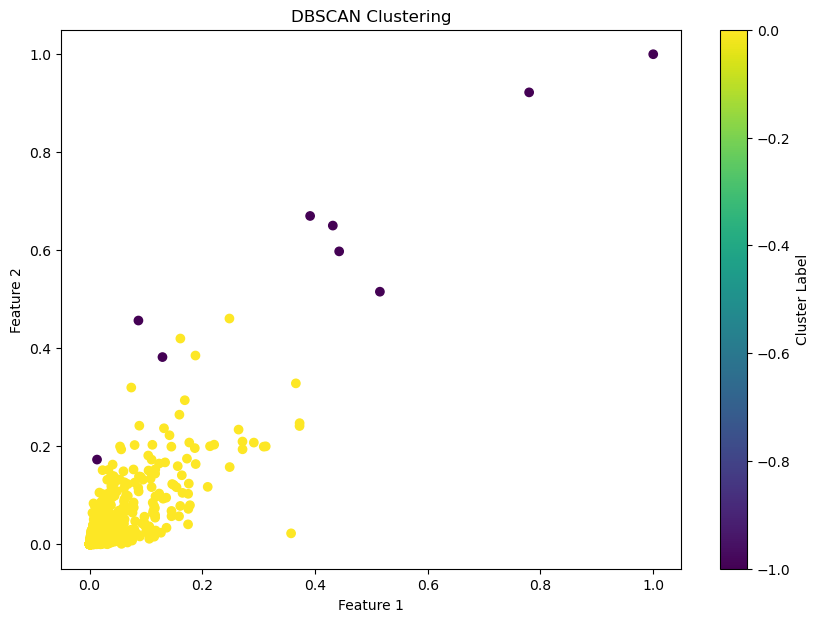

In [279]:
plt.figure(figsize=(10, 7))
plt.scatter(final_data1.iloc[:, 2:].drop('cluster_new', axis=1).iloc[:, 0], 
            final_data1.iloc[:, 2:].drop('cluster_new', axis=1).iloc[:, 1], 
            c=labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

#### Hierarchical Clustering

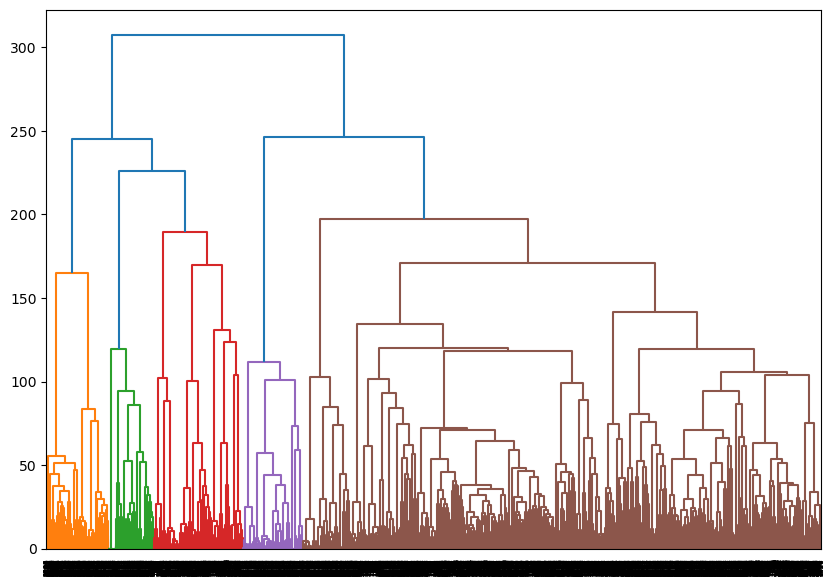

In [285]:
data_with_vectors = pd.concat([data.iloc[:,0:2],data[numerical_columns],expanded_vector_data], axis=1)
plt.figure(figsize=(10, 7))
sch.dendrogram(sch.linkage(data_with_vectors.iloc[:,2:], method='ward'))
plt.show()

The optimal number of clusters is: 98

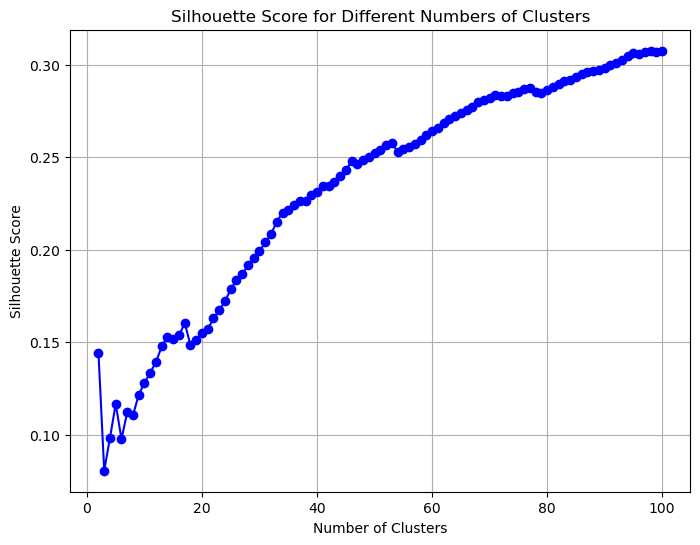

In [289]:
range_n_clusters = range(2,101)
silhouette_scores = []
for n_clusters in range_n_clusters:
    agg_clust = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward')
    cluster_labels = agg_clust.fit_predict(data_with_vectors.iloc[:,2:])
    silhouette_avg = silhouette_score(data_with_vectors.iloc[:,2:], cluster_labels)
    silhouette_scores.append(silhouette_avg)
best_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is: {best_n_clusters}")

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='b', label='Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Final Silhouette Score with 98 clusters: 0.42481484795912644

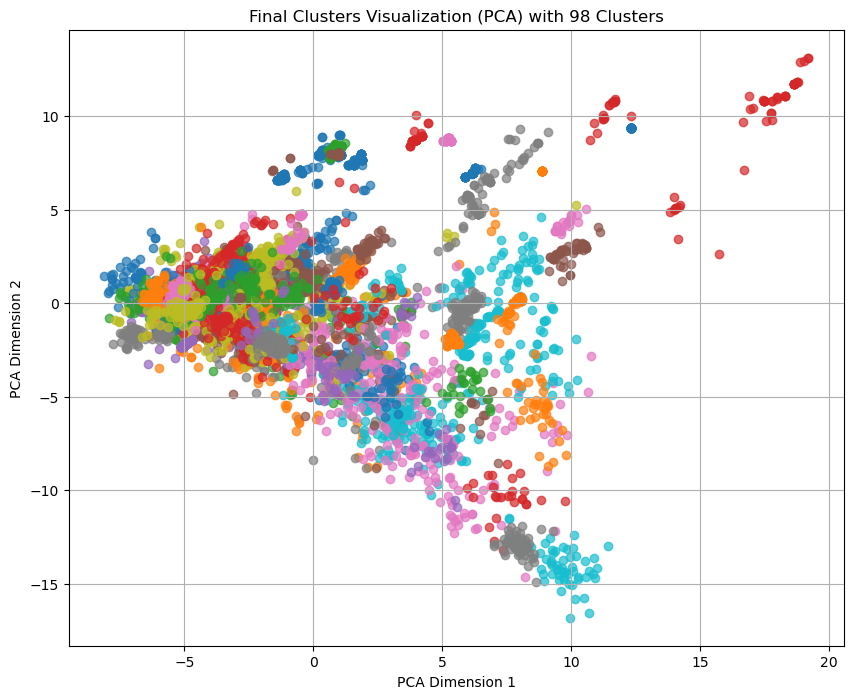

In [291]:
agg_clust = AgglomerativeClustering(n_clusters=best_n_clusters, linkage='ward')
final_cluster_labels = agg_clust.fit_predict(data_with_vectors.iloc[:,2:])
final_silhouette_score = silhouette_score(data_with_vectors.iloc[:,2:], final_cluster_labels)
print(f"Final Silhouette Score with {best_n_clusters} clusters: {final_silhouette_score}")

data_with_vectors['cluster'] = final_cluster_labels
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(data_with_vectors.iloc[:,2:].drop(columns=['cluster']))
data_with_vectors['pca_x'] = X_pca[:, 0]
data_with_vectors['pca_y'] = X_pca[:, 1]

plt.figure(figsize=(10, 8))
for cluster in range(best_n_clusters):
    clustered_points = data_with_vectors[data_with_vectors['cluster'] == cluster]
    plt.scatter(clustered_points['pca_x'], clustered_points['pca_y'], label=f"Cluster {cluster}", alpha=0.7)

plt.title(f"Final Clusters Visualization (PCA) with {best_n_clusters} Clusters")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.grid(True)
plt.show()

In [292]:
db_score = davies_bouldin_score(data_with_vectors.iloc[:,2:].drop(columns='cluster'), final_cluster_labels)
ch_index = calinski_harabasz_score(data_with_vectors.iloc[:,2:].drop(columns='cluster'), final_cluster_labels)

print(f"Davies-Bouldin Score: {db_score}")
print(f"Calinski-Harabasz Index: {ch_index}")

Davies-Bouldin Score: 1.5560944560745866

Calinski-Harabasz Index: 209.35639783111242

### Conclusion 

First we have done clustering on numerical and textual data but the silhouette score is very poor then we switched to a different methods. First we have done based on textual data then we applied clustering again with the textual data, this helped improving the silhouette score in kmeans but in dbscan it didn't help. Then we got into hierarchical with the textual data and numerical data together but if we try to increase silhouette score the number of clusters got increased and considered individual points as individual cluster to get a higher score.

The main use case of this assignment can be simple recommendation system. This can be done by observing the users most watched recent videos and of the trending similar videos.